Author: [Benjamin Bertincourt](http://fr.linkedin.com/in/bbertincourt)

Data Science Central Time Series Analysis: identifying patterns in complex time series
===============================================

Our new challenge is about identifying periodicity (simple or multiple) and especially periodic peaks occurring in each cycle, in the [attached spreadsheet](http://api.ning.com/files/yallYWJbJ*ZlzQE9kdHoJE5Fp1WJhsByc-KMnywmkwYykxsLC7ZaaOLfZpsd08L5To-st3hYJumfbY*dcZxyMWiMzTRdRznV/DSC2t.xlsx), after taking into account seasonality, outliers (e.g. Christmas day), noise, and messy data.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


##1 - Importing the data

We are using the Pandas library for data and time series manipulation.

In [2]:
import pandas as pd

In [92]:
pd.options.display.max_rows = 15

The data is stored in data/DSC2t/dsc2t.csv . Note that the original file has been edited in OpenOffice to edit out the comas in the thousand notation of pageviews and saved as a .csv file with semicolon separators.

In [3]:
path_to_data = '/Users/benjamin/Data/DSC/DSC2t/'

data = pd.read_csv(path_to_data+'dsc2t.csv', sep=';')

In [4]:
data.head()

,Website #1,Unnamed: 1
0,Day,Pageviews
1,1/1/2015,11713.00
2,1/2/2015,15698.00
3,1/3/2015,10998.00
4,1/4/2015,12116.00


We reformat slightly the data frame to the proper column names, edit out the first row and convert the first column to DateTimeIndex.

In [5]:
data.columns = [u'Day', u'Pageviews']
data = data[1:]
data.Day = pd.to_datetime(data.Day)

In [6]:
data.head()

,Day,Pageviews
1,2015-01-01,11713.00
2,2015-01-02,15698.00
3,2015-01-03,10998.00
4,2015-01-04,12116.00
5,2015-01-05,18035.00


##2 - Plotting the data

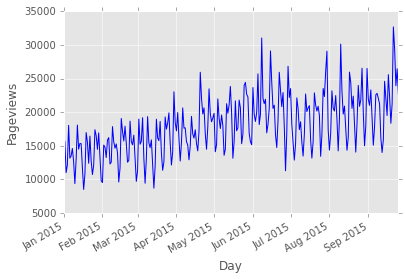

In [15]:
style.use('ggplot')
plot(data.Day, data.Pageviews, 'b-')
gcf().autofmt_xdate()
xlabel('Day')
ylabel('Pageviews')

##3 - Convert to Time Serie

In [34]:
serie = data.Pageviews.apply(float)
serie.index = pd.date_range(min(data.Day), max(data.Day), freq='D')

serie.head()

2015-01-01    11713
2015-01-02    15698
2015-01-03    10998
2015-01-04    12116
2015-01-05    18035
Freq: D, Name: Pageviews, dtype: float64

In [35]:
serie.describe()

count      268.000000
mean     17963.529851
std       4403.654203
min       8497.000000
25%      15059.000000
50%      17644.500000
75%      20880.750000
max      32687.000000
Name: Pageviews, dtype: float64

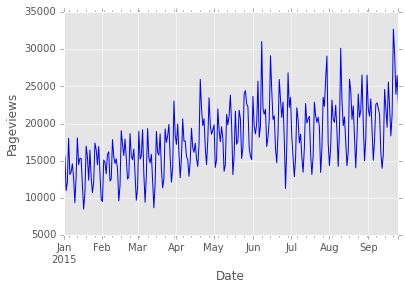

In [164]:
serie.plot(style='b-')
xlabel('Date')
ylabel('Pageviews')

We can split the serie per days of the week.

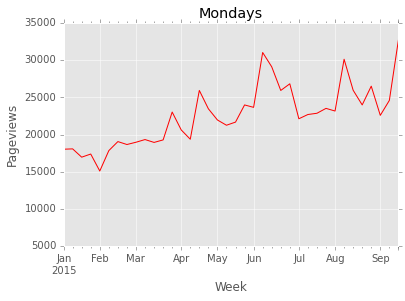

In [88]:
mondays = serie[serie.index.dayofweek == 0]
sundays = serie[serie.index.dayofweek == 6]

mondays.plot(style='r-', label='Series')
ylim([5000,35000])
xlabel('Week')
ylabel('Pageviews')
title('Mondays')

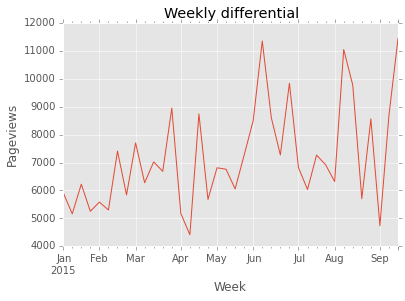

In [89]:
weekdiff = pd.Series(asarray(mondays)-asarray(sundays), index=mondays.index)
weekdiff.plot()
xlabel('Week')
ylabel('Pageviews')
title('Weekly differential')

##4 - First order Time Serie Analysis

### Variability

In [93]:
serie.pct_change()

2015-01-01         NaN
2015-01-02    0.340220
2015-01-03   -0.299401
2015-01-04    0.101655
2015-01-05    0.488528
2015-01-06   -0.270363
2015-01-07    0.024470
                ...   
2015-09-19   -0.175071
2015-09-20    0.158406
2015-09-21    0.538646
2015-09-22   -0.100958
2015-09-23   -0.185899
2015-09-24    0.105961
2015-09-25   -0.141426
Freq: D, Name: Pageviews, dtype: float64

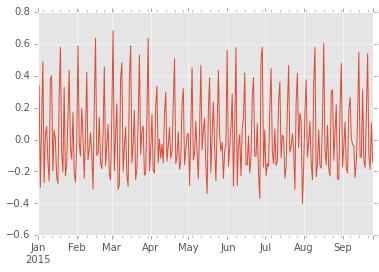

In [125]:
serie.pct_change().plot()

In [126]:
serie.pct_change().describe()

count    267.000000
mean       0.029478
std        0.244727
min       -0.401830
25%       -0.161252
50%       -0.030410
75%        0.171928
max        0.683496
Name: Pageviews, dtype: float64

### Periodicity

The first level of periodicity is at the week level. We test this here.

In [137]:
nelts = len(serie)
ndays = 30
corr_arr = array([corrcoef(asarray(serie[0:nelts-i]), asarray(serie[i:]))[0, 1] for i in range(ndays)])
corr_arr[7]

0.82421050637951521

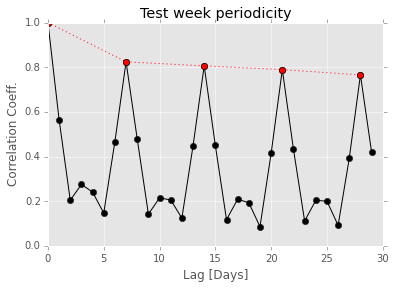

In [142]:
plot(range(ndays), corr_arr, 'ko-')
idx = range(0,29,7)
plot(idx, corr_arr[idx], 'ro:')
xlabel('Lag [Days]')
ylabel('Correlation Coeff.')
title('Test week periodicity')

### Large scale behavior

There is clear evolution/trends underlying the weekly periodicity. We try here to highlight it.

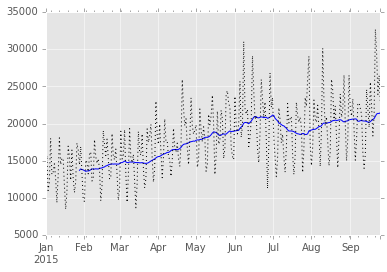

In [154]:
pd.rolling_mean(serie, 28).plot(style='b', ylim=[5000,35000])
serie.plot(style='k:')

The rolling mean with a month long window is qualitatively informative but quantitatively inaccurate to estimate a baseline. Instead we can use the minimum pageview per week as a baseline or a specific day (for convenience a day that repeatedly gives low values to keep the comparison in positive pageviews above the baseline).

In [162]:
dictdata = {'week': pd.Series(serie.index.week, index=serie.index),
           'weekday': pd.Series(serie.index.weekday, index=serie.index),
           'pageviews': serie}

extdata = pd.DataFrame(dictdata)
extdata.head()

,pageviews,week,weekday
2015-01-01,11713,1,3
2015-01-02,15698,1,4
2015-01-03,10998,1,5
2015-01-04,12116,1,6
2015-01-05,18035,2,0


In [166]:
grouped_by_week = extdata.groupby('week')
grouped_by_weekday = extdata.groupby('weekday')

In [182]:
for k, group in grouped_by_week:
    print k
    print group
    if k > 1:
        break

1
            pageviews  week  weekday
2015-01-01      11713     1        3
2015-01-02      15698     1        4
2015-01-03      10998     1        5
2015-01-04      12116     1        6
2
            pageviews  week  weekday
2015-01-05      18035     2        0
2015-01-06      13159     2        1
2015-01-07      13481     2        2
2015-01-08      14593     2        3
2015-01-09      12649     2        4
2015-01-10       9363     2        5
2015-01-11      12920     2        6


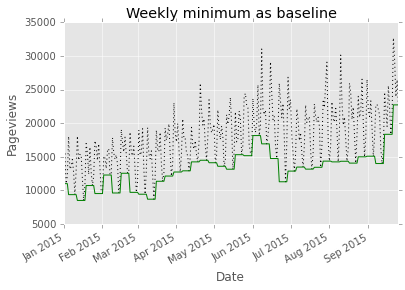

In [193]:
weekly_baseline = [min(group.pageviews) for k, group in grouped_by_week]

baseline_serie = pd.Series([weekly_baseline[k-1] for k in extdata.week], index=serie.index)

plot(extdata.index, extdata.pageviews, 'k:')
baseline_serie.plot(style='g-', ylim=[5000,35000])
xlabel('Date')
ylabel('Pageviews')
title('Weekly minimum as baseline')

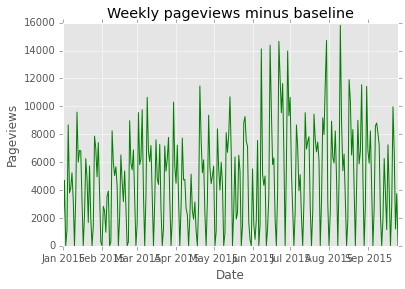

In [194]:
plot(extdata.index, extdata.pageviews - baseline_serie, 'g-')
xlabel('Date')
ylabel('Pageviews')
title('Weekly pageviews minus baseline')

### Low scale behavior

After estimating a baseline for each week, we study here the behavior of the pageviews inside each week.

(5000, 35000)

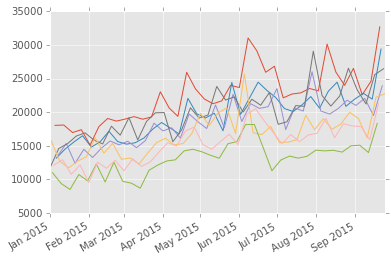

In [195]:
for k, group in grouped_by_weekday:
    plot(group.index, group.pageviews)

gcf().autofmt_xdate()    
ylim([5000,35000])

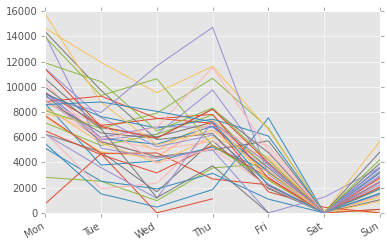

In [277]:
dayoftheweek = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']

ax = subplot(111)
for k, group in grouped_by_week:
    ax.plot(group.pageviews-weekly_baseline[k-1])
    
ax.set_xticklabels(dayoftheweek)
gcf().autofmt_xdate()

In [278]:
weekly_pageviews_mat = [array(group.pageviews-weekly_baseline[k-1]) 
                        for k, group in grouped_by_week] 
weekly_pageviews_data = pd.DataFrame(weekly_pageviews_mat)

weekly_pageviews_data.columns = dayoftheweek
weekly_pageviews_data = weekly_pageviews_data[1:]
weekly_pageviews_data.head()

,Mon,Tue,Wed,Thu,Fri,Sat,Sun
1,8672,3796,4118,5230,3286,0,3557
2,9584,5997,6836,6812,3225,0,2248
3,6250,4834,1673,5726,1995,0,1417
4,7863,6964,4944,7397,3828,255,0
5,2823,2516,970,3569,3929,0,270


In [279]:
stats = weekly_pageviews_data.describe()
stats = stats.transpose()
stats

,count,mean,std,min,25%,50%,75%,max
Mon,38,9233.631579,2783.935038,2823,7757.25,8949.0,10218.25,15799
Tue,38,6253.000000,2311.483974,1515,4913.00,5986.5,7447.25,11953
Wed,38,5244.710526,2573.279976,462,4018.25,5314.5,6676.00,11665
Thu,38,6827.315789,2531.722820,1848,5336.75,6844.0,7689.25,14723
Fri,38,3488.236842,1696.667297,0,2368.25,3305.5,4271.50,7548
Sat,37,52.567568,217.794442,0,0.00,0.0,0.00,1243
Sun,37,2389.108108,1302.441954,0,1529.00,2446.0,3202.00,5707


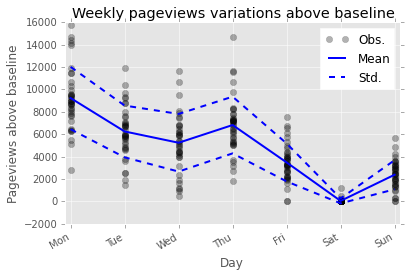

In [282]:
ax = subplot(111)
for k in range(len(weekly_pageviews_data)):
    dots, = ax.plot(weekly_pageviews_data.loc[k+1,:], 'ko', alpha=0.3, label='Obs.')
meanline, = ax.plot(stats['mean'], 'b-', linewidth=2, label='Mean')
stdline, = ax.plot(stats['mean']+stats['std'], 'b--', linewidth=2, label='Std.')
ax.plot(stats['mean']-stats['std'], 'b--', linewidth=2)
ax.set_xticks(range(7))
ax.set_xticklabels(dayoftheweek)
ax.set_xlim([-0.1,6.1])
xlabel('Day')
ylabel('Pageviews above baseline')
title('Weekly pageviews variations above baseline')
legend = ax.legend(handles=[dots, meanline, stdline])
frame = legend.get_frame()
frame.set_facecolor('white')
gcf().autofmt_xdate()

We see that there are two clear peeks of pageviews per week, on Mondays and Thursdays. The deviation around the mean is large though and could be strongly affected by outliers. 
We show below that the distribution of pageviews per days of the week are not well represented by a normal distribution whether because we have limited statistics (thus outliers have a stronger effect) or because the distribution is inherently non-gaussian (seasonal variations along the year that would not be accounted for in the baseline such as special monday articles during the summer months ... ).

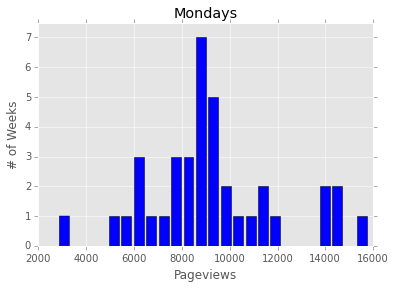

In [299]:
n, bins, patches = hist(array(weekly_pageviews_data['Mon']), 25, 
                        histtype='bar', rwidth=0.8, color='b', edgecolor='k')
ylim([0,max(n)+0.5])
xlabel('Pageviews')
ylabel('# of Weeks')
title('Mondays')

We will assume here that the distribution is centered and symmetric. Any skewness will be attributed to outliers. This assumption will be part of the model so as to use its mean as center point and estimate its variance using MAD (less susceptible to outliers).

*__Note__: Positive outliers above the mean are particularly interesting in this context. One might consider studying those outliers in hope to reproduce them (and thus move the whole pageview distribution up in the future).*

In [305]:
from scipy.stats import skew, skewtest
print skew(array(weekly_pageviews_data['Mon']))
print skewtest(array(weekly_pageviews_data['Mon']))

0.434986581879
(1.2179295639779073, 0.22325074040262471)


In [377]:
mean_mondays = stats.loc['Mon','mean']  # used as center point
mad_mondays = median(abs(array(weekly_pageviews_data['Mon']) - mean_mondays))

print 'Standard Deviation = {0:.2f}'.format(std(array(weekly_pageviews_data['Mon'])))
print 'MAD = {0:.2f}'.format(mad_mondays)

Standard Deviation = 2747.06
MAD = 1393.00


### Detecting outliers

We self-define outliers for the purpose of this study as anything above center + 3\*MAD that sums to more than 1-2% of the total number of observations. With 39 weeks, that means we can tolerate no more than 1 observation above this limit ("luck of the draw" type of effect as the problem is discrete).

In [378]:
pageviews_pos_lim = mean_mondays + 3*mad_mondays
idx, = where(bins[1:] - mean(bins[1:] - bins[0:25]) > pageviews_pos_lim)
fraction_pos_out = sum(n[idx]) / sum(n)

print "Fraction of positive outliers = {0:.2f}%".format(fraction_pos_out * 100)

Fraction of positive outliers = 13.16%


This definition of outliers is very empirical. In the context of a normally distributed number of page views per day, this definition would potentially select too many outliers. At this point we would rather detect too many outliers than too little.